# Kaggle San Francisco Crime Classification
## Berkeley MIDS W207 Final Project: Sam Goodgame, Sarah Cha, Kalvin Kao, Bryan Moore



### Environment and Data

In [87]:
# Additional Libraries
%matplotlib inline
import matplotlib.pyplot as plt

# Import relevant libraries:
import time
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# Import Meta-estimators
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Import Calibration tools
from sklearn.calibration import CalibratedClassifierCV

# Set random seed and format print output:
np.random.seed(0)
np.set_printoptions(precision=3)

### Local, individual load of updated data set (with weather data integrated) into training, development, and test subsets.


In [3]:
# Data path to your local copy of Kalvin's "x_data.csv", which was produced by the negated cell above
data_path = "./data/x_data_3.csv"
df = pd.read_csv(data_path, header=0)
x_data = df.drop('category', 1)
y = df.category.as_matrix()

# Impute missing values with mean values:
#x_complete = df.fillna(df.mean())
x_complete = x_data.fillna(x_data.mean())
X_raw = x_complete.as_matrix()

# Scale the data between 0 and 1:
X = MinMaxScaler().fit_transform(X_raw)

####
X = np.around(X, decimals=2)
####

# Shuffle data to remove any underlying pattern that may exist.  Must re-run random seed step each time:
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, y = X[shuffle], y[shuffle]

test_data, test_labels = X[800000:], y[800000:]
dev_data, dev_labels = X[700000:800000], y[700000:800000]
train_data, train_labels = X[:700000], y[:700000]

mini_train_data, mini_train_labels = X[:200000], y[:200000]
mini_dev_data, mini_dev_labels = X[430000:480000], y[430000:480000]

crime_labels = list(set(y))
crime_labels_mini_train = list(set(mini_train_labels))
crime_labels_mini_dev = list(set(mini_dev_labels))
print(len(crime_labels), len(crime_labels_mini_train), len(crime_labels_mini_dev))

print(len(train_data),len(train_labels))
print(len(dev_data),len(dev_labels))
print(len(mini_train_data),len(mini_train_labels))
print(len(mini_dev_data),len(mini_dev_labels))
print(len(test_data),len(test_labels))

39 39 39
700000 700000
100000 100000
200000 200000
50000 50000
78049 78049


### Logistic Regression

###### Hyperparameter tuning:

For the Logistic Regression classifier, we can seek to optimize the following classifier parameters: penalty (l1 or l2), C (inverse of regularization strength), solver ('newton-cg', 'lbfgs', 'liblinear', or 'sag')

###### Model calibration:

See above


## Fit the Best LR Parameters

In [4]:
bestLR = LogisticRegression(penalty='l2', solver='newton-cg', tol=0.01, C=500)
bestLR.fit(mini_train_data, mini_train_labels)

LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.01,
          verbose=0, warm_start=False)

In [5]:
bestLRPredictions = bestLR.predict(mini_dev_data)
bestLRPredictionProbabilities = bestLR.predict_proba(mini_dev_data)

In [6]:
print("L1 Multi-class Log Loss:", log_loss(y_true = mini_dev_labels, y_pred = bestLRPredictionProbabilities, \
                                           labels = crime_labels_mini_dev), "\n\n")

L1 Multi-class Log Loss: 2.59276763905 




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024682C052B0>]], dtype=object)

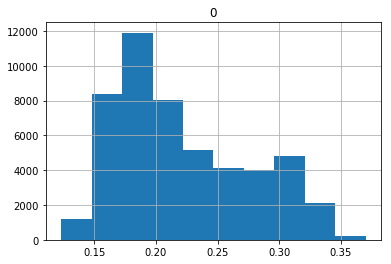

In [69]:
pd.DataFrame(np.amax(bestLRPredictionProbabilities, axis=1)).hist()

## Error Analysis: Calibration

In [74]:
#clf_probabilities, clf_predictions, labels
def error_analysis_calibration(buckets, clf_probabilities, clf_predictions, labels):
    """inputs:
    clf_probabilities = clf.predict_proba(dev_data)
    clf_predictions = clf.predict(dev_data)
    labels = dev_labels"""
    
    #buckets = [0.05, 0.15, 0.3, 0.5, 0.8]
    #buckets = [0.15, 0.25, 0.3, 1.0]
    correct = [0 for i in buckets]
    total = [0 for i in buckets]

    lLimit = 0
    uLimit = 0
    for i in range(len(buckets)):
        uLimit = buckets[i]
        for j in range(clf_probabilities.shape[0]):
            if (np.amax(clf_probabilities[j]) > lLimit) and (np.amax(clf_probabilities[j]) <= uLimit):
                if clf_predictions[j] == labels[j]:
                    correct[i] += 1
                total[i] += 1
        lLimit = uLimit
        
    print(sum(correct))
    print(sum(total))
    print(correct)
    print(total)

    #here we report the classifier accuracy for each posterior probability bucket
    accuracies = []
    for k in range(len(buckets)):
        print(1.0*correct[k]/total[k])
        accuracies.append(1.0*correct[k]/total[k])
        print('p(pred) <= %.13f    total = %3d    correct = %3d    accuracy = %.3f' \
              %(buckets[k], total[k], correct[k], 1.0*correct[k]/total[k]))
    plt.plot(buckets,accuracies)
    plt.title("Calibration Analysis")
    plt.xlabel("Posterior Probability")
    plt.ylabel("Classifier Accuracy")
    
    return buckets, accuracies

In [ ]:
#i think you'll need to look at how the posteriors are distributed in order to set the best bins in 'buckets'
pd.DataFrame(np.amax(bestLRPredictionProbabilities, axis=1)).hist()

11246
50000
[199, 6513, 2458, 2076]
[1351, 33941, 8338, 6370]
0.14729829755736493
p(pred) <= 0.1500000000000    total = 1351    correct = 199    accuracy = 0.147
0.19189181226245544
p(pred) <= 0.2500000000000    total = 33941    correct = 6513    accuracy = 0.192
0.2947949148476853
p(pred) <= 0.3000000000000    total = 8338    correct = 2458    accuracy = 0.295
0.3259026687598116
p(pred) <= 1.0000000000000    total = 6370    correct = 2076    accuracy = 0.326


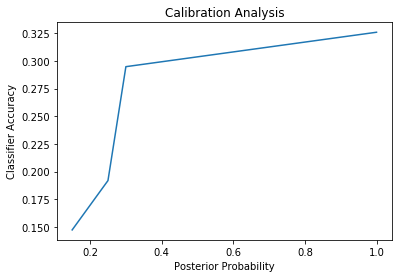

In [75]:
buckets = [0.15, 0.25, 0.3, 1.0]
calibration_buckets, calibration_accuracies = error_analysis_calibration(buckets, clf_probabilities=bestLRPredictionProbabilities, \
                                                                         clf_predictions=bestLRPredictions, \
                                                                         labels=mini_dev_labels)

## Error Analysis: Classification Report

In [77]:
def error_analysis_classification_report(clf_predictions, labels):
    """inputs:
    clf_predictions = clf.predict(dev_data)
    labels = dev_labels"""
    print('Classification Report:')
    report = classification_report(labels, clf_predictions)
    print(report)
    return report

In [78]:
classification_report = error_analysis_classification_report(clf_predictions=bestLRPredictions, \
                                                            labels=mini_dev_labels)

Classification Report:
                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00        94
                    ASSAULT       0.23      0.00      0.00      4427
                 BAD CHECKS       0.00      0.00      0.00        27
                    BRIBERY       0.00      0.00      0.00        14
                   BURGLARY       0.00      0.00      0.00      2047
         DISORDERLY CONDUCT       0.00      0.00      0.00       243
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       157
              DRUG/NARCOTIC       0.24      0.31      0.27      3009
                DRUNKENNESS       0.00      0.00      0.00       254
               EMBEZZLEMENT       0.00      0.00      0.00        61
                  EXTORTION       0.00      0.00      0.00        14
            FAMILY OFFENSES       0.00      0.00      0.00        25
     FORGERY/COUNTERFEITING       0.00      0.00      0.00       594
          

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Error Analysis: Confusion Matrix

In [99]:
crime_labels_mini_dev

['TREA',
 'DISORDERLY CONDUCT',
 'BAD CHECKS',
 'SECONDARY CODES',
 'FORGERY/COUNTERFEITING',
 'SEX OFFENSES NON FORCIBLE',
 'RUNAWAY',
 'BURGLARY',
 'DRIVING UNDER THE INFLUENCE',
 'DRUG/NARCOTIC',
 'LOITERING',
 'VANDALISM',
 'STOLEN PROPERTY',
 'OTHER OFFENSES',
 'NON-CRIMINAL',
 'GAMBLING',
 'FAMILY OFFENSES',
 'VEHICLE THEFT',
 'ARSON',
 'PORNOGRAPHY/OBSCENE MAT',
 'ROBBERY',
 'SUICIDE',
 'SEX OFFENSES FORCIBLE',
 'EMBEZZLEMENT',
 'EXTORTION',
 'WEAPON LAWS',
 'KIDNAPPING',
 'MISSING PERSON',
 'SUSPICIOUS OCC',
 'TRESPASS',
 'WARRANTS',
 'ASSAULT',
 'LARCENY/THEFT',
 'PROSTITUTION',
 'BRIBERY',
 'FRAUD',
 'LIQUOR LAWS',
 'DRUNKENNESS',
 'RECOVERED VEHICLE']

In [104]:
def error_analysis_confusion_matrix(label_names, clf_predictions, labels):
    """inputs:
    clf_predictions = clf.predict(dev_data)
    labels = dev_labels"""
    cm = pd.DataFrame(confusion_matrix(labels, clf_predictions, labels=label_names))
    cm.columns=label_names
    cm.index=label_names
    cm.to_csv(path_or_buf="./confusion_matrix.csv")
    #print(cm)
    return cm

In [105]:
error_analysis_confusion_matrix(label_names=crime_labels_mini_dev, clf_predictions=bestLRPredictions, \
                                                            labels=mini_dev_labels)

,TREA,DISORDERLY CONDUCT,BAD CHECKS,SECONDARY CODES,FORGERY/COUNTERFEITING,SEX OFFENSES NON FORCIBLE,RUNAWAY,BURGLARY,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,...,TRESPASS,WARRANTS,ASSAULT,LARCENY/THEFT,PROSTITUTION,BRIBERY,FRAUD,LIQUOR LAWS,DRUNKENNESS,RECOVERED VEHICLE
TREA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
DISORDERLY CONDUCT,0,0,0,0,0,0,0,0,0,28,...,0,0,0,136,0,0,0,0,0,0
BAD CHECKS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,21,0,0,0,0,0,0
SECONDARY CODES,0,0,0,0,0,0,0,0,0,42,...,0,0,0,324,0,0,0,0,0,0
FORGERY/COUNTERFEITING,0,0,0,0,0,0,0,0,0,28,...,0,0,1,387,0,0,0,0,0,0
SEX OFFENSES NON FORCIBLE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
RUNAWAY,0,0,0,0,0,0,0,0,0,1,...,0,0,0,67,0,0,0,0,0,0
BURGLARY,0,0,0,0,0,0,0,0,0,58,...,0,0,0,1399,0,0,0,0,0,0
DRIVING UNDER THE INFLUENCE,0,0,0,0,0,0,0,0,0,2,...,0,0,0,93,0,0,0,0,0,0
DRUG/NARCOTIC,0,0,0,0,0,0,0,0,0,943,...,0,0,1,1341,0,0,0,0,0,0
